<a href="https://colab.research.google.com/github/Redwoods/Py/blob/master/pdm2020/my-note/py-tensorflow/DL3-TL/cifar10_10pct_TL123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer learning

## dataset
- 10 % of **cifar10** dataset

## ConvNet model
- EfficientNetB1


## Transfer learning in 3 steps
1. Full convnet using untrainable parameters
2. Half convnet using the post half trainable parameters
3. Using the whole trainable parameters

In [1]:
# import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import numpy as np
import random


### Load cifar10 datset

In [2]:
# CFAR-10 데이터 세트를 적재한다.
# 훈련 세트와 테스트 세트를 반환받는다. 
# # Use the below when you can not load cifar10 dataset
# import ssl
# ssl._create_default_https_context = ssl._create_unverified_context

(X_train, y_train), (X_test, y_test) = keras.datasets.cifar10.load_data()
print(X_train.shape, y_train.shape)
y_train=np.squeeze(y_train, 1)
y_test=np.squeeze(y_test, 1)
print(X_train.shape, y_train.shape)

NUM_CLASSES = np.unique(y_train).size
print(NUM_CLASSES)

label_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


170498071/170498071 [==============================] - 3s 0us/step
(50000, 32, 32, 3) (50000, 1)
(50000, 32, 32, 3) (50000,)
10


### Prepare 10 % of cifar10 dataset

In [3]:
#
# Select 10 % of the data
#
def select_part_indices(labels_data, pct = 0.1, num_labels=10):  # default 10 % from whole data
    part_indices = np.array([])
    part = int(len(labels_data)/num_labels*pct)  # 10 %
    for i in range(num_labels):
        idx = np.nonzero(labels_data == i)[0]
        part_indices = np.append(part_indices, idx[:part]).astype(int)
    # part_indices = random.shuffle(part_indices)
    return part_indices

# pct = 0.0,0.1,...,1.0 (0% ~ 100%)
# 100% = 1.0
pct=0.1  # 10 %
part_indices_train = select_part_indices(y_train, pct)
part_indices_test = select_part_indices(y_test, pct)
print(part_indices_train.shape, part_indices_test.shape)
random.shuffle(part_indices_train)
random.shuffle(part_indices_test)
print(part_indices_train.shape, part_indices_test.shape)
#  Check
print(y_train[part_indices_train].shape,y_test[part_indices_test].shape)
#? 10 % data
X_train10 = X_train[part_indices_train]
X_test10 = X_test[part_indices_test]
y_train10 = y_train[part_indices_train]
y_test10 = y_test[part_indices_test]
X_train10.shape,y_train10.shape,X_test10.shape,y_test10.shape

(5000,) (1000,)
(5000,) (1000,)
(5000,) (1000,)


((5000, 32, 32, 3), (5000,), (1000, 32, 32, 3), (1000,))

### tensorflow dataset 
- Batch_size = 64

In [5]:
# 10 % data
# tensorflow dataset 구성 : Batch_size = 64
#
dataset = tf.data.Dataset.from_tensor_slices((X_train10, y_train10))
print(str(dataset))
# prefetch는 데이터 로딩과 학습이 병렬적으로 이루어져서 데이터 로딩에서 
# 병목 현상이 일어나는 것을 방지하기 위하여 사용하였다.
dataset = dataset.prefetch(tf.data.AUTOTUNE)
print(str(dataset))

# Test using batch_size = 10
# 1. 순서대로 10개씩 배치 구성
ds0 = dataset.batch(10)  # 순서대로 10개씩 배치 구성
print(str(ds0))

for i, (image, label) in enumerate(ds0.take(5)):
    print(i, image.shape, label)
    
print(y_train10[:10])
print(y_train10[10:20])
print(y_train10[20:30])

# 2. 마구 섞어서 10개씩 배치 구성
# shuffle(100000).repeat().batch()
ds1 = dataset.shuffle(100000).repeat().batch(10)  # 마구 섞어서 배치 구성
print(str(ds1))

for i, (image, label) in enumerate(ds1.take(5)):
    print(i, image.shape, label)
    
# Check
len(ds0)  # 5000/10 = 500
len(ds1)  # TypeError: The dataset is infinite.


<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
<PrefetchDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dtype=tf.uint8, name=None))>
0 (10, 32, 32, 3) tf.Tensor([7 3 8 4 1 9 9 1 0 7], shape=(10,), dtype=uint8)
1 (10, 32, 32, 3) tf.Tensor([8 6 5 1 8 1 3 6 9 0], shape=(10,), dtype=uint8)
2 (10, 32, 32, 3) tf.Tensor([3 0 6 5 8 3 3 3 4 4], shape=(10,), dtype=uint8)
3 (10, 32, 32, 3) tf.Tensor([1 7 2 5 8 8 7 8 5 8], shape=(10,), dtype=uint8)
4 (10, 32, 32, 3) tf.Tensor([4 4 8 8 9 3 4 7 0 0], shape=(10,), dtype=uint8)
[7 3 8 4 1 9 9 1 0 7]
[8 6 5 1 8 1 3 6 9 0]
[3 0 6 5 8 3 3 3 4 4]
<BatchDataset element_spec=(TensorSpec(shape=(None, 32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(None,), dty

TypeError: ignored

0 (64, 32, 32, 3) (64,)
<TensorSliceDataset element_spec=(TensorSpec(shape=(32, 32, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.uint8, name=None))>
0 (64, 32, 32, 3) (64,)
0 (64, 128, 128, 3) (64,)
(64, 128, 128, 3)


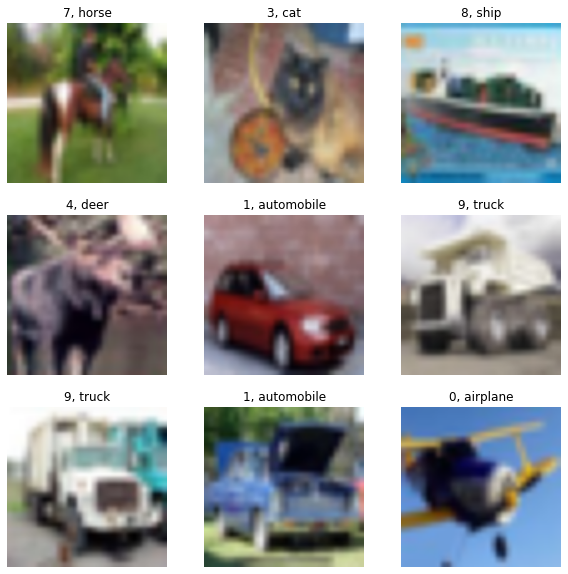


 ################################################################################ 



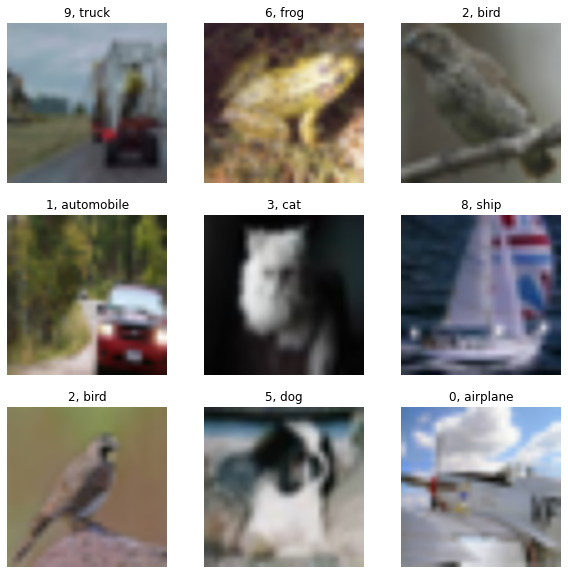

In [9]:
# 
# tensorflow batchDataset를 이용해서 train/test dataset 구성 
#
Batch_size = 64
ds_train = dataset.batch(Batch_size)  # 순서대로 64개씩 배치 구성
for i, (image, label) in enumerate(ds_train.take(1)):
    print(i, image.shape, label.shape)
    
# test dataset
dataset2 = tf.data.Dataset.from_tensor_slices((X_test10, y_test10))
print(str(dataset2))
dataset2 = dataset2.prefetch(tf.data.AUTOTUNE)
ds_test = dataset2.batch(Batch_size)  # 순서대로 64개씩 배치 구성
for i, (image, label) in enumerate(ds_test.take(1)):
    print(i, image.shape, label.shape)

# Resize image for transfer learning
IMG_SIZE = 128
size = (IMG_SIZE, IMG_SIZE)
ds_train = ds_train.map(lambda image, label: (tf.image.resize(image, size), label))
ds_test = ds_test.map(lambda image, label: (tf.image.resize(image, size), label))

str(ds_train)  # MapDataset
for i, (image, label) in enumerate(ds_train.take(1)):
    print(i, image.shape, label.shape)

### Visualizing the data
# The following code shows the first 9 images with their labels.

# figure 크기를 조절합니다.
plt.figure(figsize=(10, 10))
# 배치 하나를 가져옵니다.
for images, labels in ds_train.take(1):    # Make a batch of images & labels
    print(images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))  # tensor2numpy array: tensor.numpy()
        # plt.title(label_names[int(labels[i])])
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()
print('\n',"#"*80,'\n')
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):    # Make a batch of images & labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # plt.title(label_names[int(labels[i])])
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()


### Data augmentation

tf.Tensor(
[7 3 8 4 1 9 9 1 0 7 8 6 5 1 8 1 3 6 9 0 3 0 6 5 8 3 3 3 4 4 1 7 2 5 8 8 7
 8 5 8 4 4 8 8 9 3 4 7 0 0 2 3 1 1 6 7 5 4 5 4 7 9 7 7], shape=(64,), dtype=uint8) (64, 128, 128, 3)
(1, 139, 130, 3)
(1, 122, 125, 3)
(1, 125, 138, 3)
(1, 129, 131, 3)
(1, 133, 135, 3)
(1, 139, 137, 3)
(1, 125, 125, 3)
(1, 134, 138, 3)
(1, 123, 140, 3)


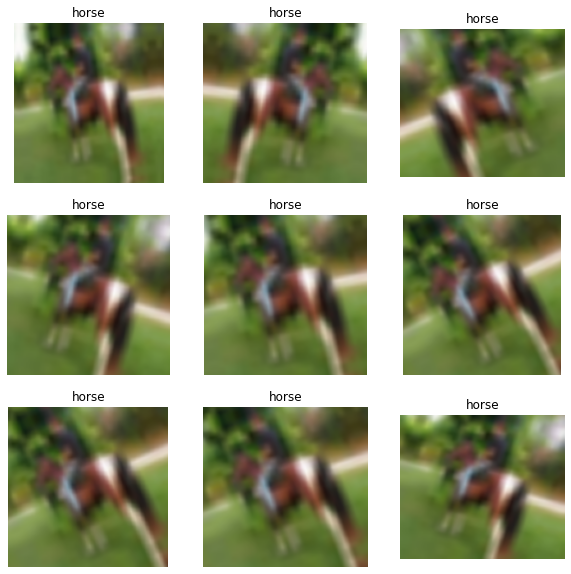

In [10]:
#
# Data augmentation
#
from tensorflow.keras import layers
tf.get_logger().setLevel('ERROR')  # Clear warnings in data augmentation
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(factor=0.1),
  layers.RandomZoom(0.1),
  # layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  layers.RandomHeight(0.1),
  layers.RandomWidth(0.1),
  # layers.Rescaling(1./255) # keep for ResNet50V2, remove for EfficientNetB0
], name ="data_augmentation")

# Plot the augmented images
plt.figure(figsize=(10,10))
image_idx = 0
for images, labels in ds_train.take(1):    # Make a batch of images & labels
    print(labels,images.shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        aug_img = data_augmentation(tf.expand_dims(images[image_idx], axis=0))
        print(aug_img.shape)
        plt.imshow(aug_img[0].numpy().astype("uint8"))
        plt.title("{}".format(label_names[labels[image_idx]]))
        plt.axis("off")
    break


### TL1. 
- Full convnet using the whole untrainable parameters
- Using the model EfficientNetB1 for the first experiment with all the layers untrainable 

27018416/27018416 [==============================] - 0s 0us/step
0 False, 1 False, 2 False, 3 False, 4 False, 5 False, 6 False, 7 False, 8 False, 9 False, 10 False, 11 False, 12 False, 13 False, 14 False, 15 False, 16 False, 17 False, 18 False, 19 False, 20 False, 21 False, 22 False, 23 False, 24 False, 25 False, 26 False, 27 False, 28 False, 29 False, 30 False, 31 False, 32 False, 33 False, 34 False, 35 False, 36 False, 37 False, 38 False, 39 False, 40 False, 41 False, 42 False, 43 False, 44 False, 45 False, 46 False, 47 False, 48 False, 49 False, 50 False, 51 False, 52 False, 53 False, 54 False, 55 False, 56 False, 57 False, 58 False, 59 False, 60 False, 61 False, 62 False, 63 False, 64 False, 65 False, 66 False, 67 False, 68 False, 69 False, 70 False, 71 False, 72 False, 73 False, 74 False, 75 False, 76 False, 77 False, 78 False, 79 False, 80 False, 81 False, 82 False, 83 False, 84 False, 85 False, 86 False, 87 False, 88 False, 89 False, 90 False, 91 False, 92 False, 93 False, 94 Fa

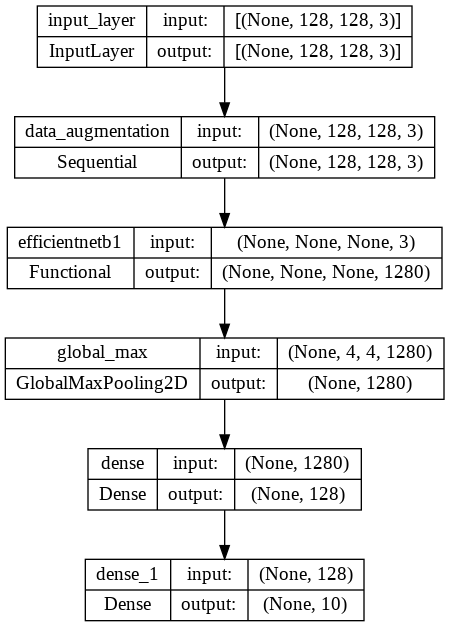

In [11]:
#
# Transfer learning
#
## Using the model EfficientNetB1 for the first experiment with all the layers untrainable 
## Creating the model 

base_model = tf.keras.applications.EfficientNetB1(include_top = False)
base_model.trainable = False  # True 

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number, layer.trainable, end=", ")
  

model = tf.keras.Sequential([
  layers.Input(shape=(128,128,3),name='input_layer'),
  # layers.Rescaling(1./255),
  data_augmentation,
  # layers.Conv2D(20,3,activation='relu',padding='same'),
  base_model,
  layers.GlobalMaxPooling2D(name = "global_max"),
  # layers.MaxPool2D(pool_size=2),
  # layers.Conv2D(64,3,activation='relu'),
  # layers.MaxPool2D(pool_size=2),
  # layers.Flatten(),
  layers.Dense(128,activation='relu'),
  layers.Dense(10,activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [12]:
# Building the Model

# Setting up the callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=10) # if val loss decreases for 5 epochs in a row, stop training
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.25, # multiply the learning rate by 0.2 (reduce by 4x)
                                                 patience=3,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

#
######################################################
# Training model using augmentated data
######################################################
#
history = model.fit(ds_train, 
                    epochs=100, 
                    steps_per_epoch = len(ds_train), 
                    validation_data = ds_test,
                    validation_steps = len(ds_test), # batchSize,
                    callbacks = [early_stopping, reduce_lr])

# Test model
model.evaluate(ds_test)

Epoch 1/100
79/79 [==============================] - 36s 259ms/step - loss: 2.0370 - accuracy: 0.3160 - val_loss: 1.2525 - val_accuracy: 0.5930 - lr: 1.0000e-04
Epoch 2/100
79/79 [==============================] - 14s 177ms/step - loss: 1.2633 - accuracy: 0.5822 - val_loss: 0.8794 - val_accuracy: 0.7180 - lr: 1.0000e-04
Epoch 3/100
79/79 [==============================] - 12s 153ms/step - loss: 1.0428 - accuracy: 0.6564 - val_loss: 0.7457 - val_accuracy: 0.7590 - lr: 1.0000e-04
Epoch 4/100
79/79 [==============================] - 11s 139ms/step - loss: 0.9230 - accuracy: 0.6952 - val_loss: 0.6803 - val_accuracy: 0.7740 - lr: 1.0000e-04
Epoch 5/100
79/79 [==============================] - 10s 127ms/step - loss: 0.8700 - accuracy: 0.7028 - val_loss: 0.6466 - val_accuracy: 0.8000 - lr: 1.0000e-04
Epoch 6/100
79/79 [==============================] - 11s 136ms/step - loss: 0.8156 - accuracy: 0.7194 - val_loss: 0.6251 - val_accuracy: 0.8050 - lr: 1.0000e-04
Epoch 7/100
79/79 [===============

[0.5343254804611206, 0.8230000138282776]

### Training graph
- loss
- accuracy

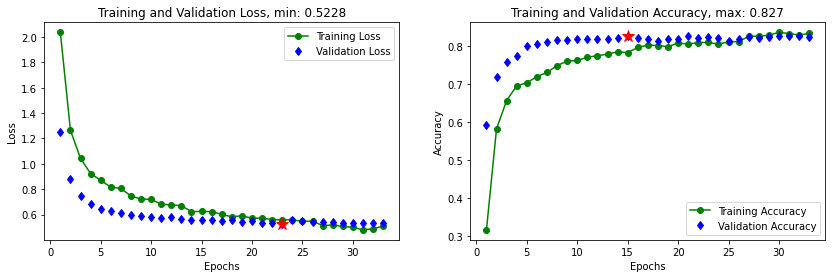

In [13]:
#############################################
# training graphs

history_dict = history.history 
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Test model


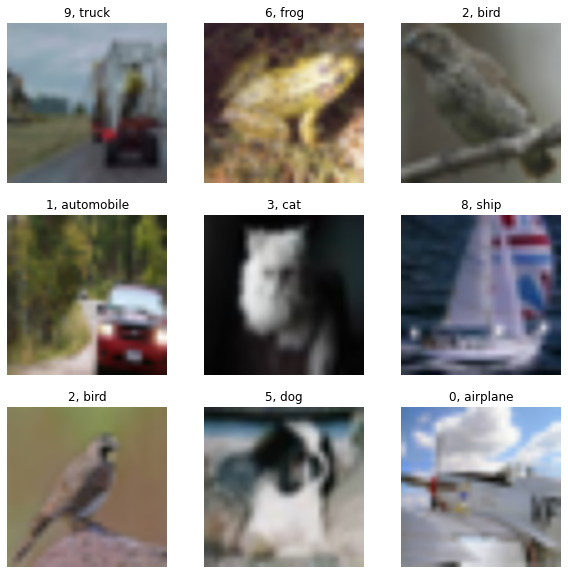

16/16 [==============================] - 1s 56ms/step
정답= 9
예측값= 9 9


0.823

In [16]:
# sample test dataset
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):  # Make a batch of images & labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()

# Test model
y_pred0 = model.predict(ds_test)
y_pred = np.argmax(y_pred0, axis=1)
y_test = [labels.numpy() for _, labels in ds_test.unbatch()]
print("정답=", y_test[0])
print("예측값=", y_pred[0], np.argmax(y_pred0[0]))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)  # model.evaluate(ds_test)

---

### TL2. 
- Half convnet using the post half trainable parameters
- Using the model EfficientNetB1 for the second experiment with the post half of the layers untrainable 

Number of layers in the base model:  340
0 input_2 False, 1 rescaling_1 False, 2 normalization_1 False, 3 tf.math.truediv_1 False, 4 stem_conv_pad False, 5 stem_conv False, 6 stem_bn False, 7 stem_activation False, 8 block1a_dwconv False, 9 block1a_bn False, 10 block1a_activation False, 11 block1a_se_squeeze False, 12 block1a_se_reshape False, 13 block1a_se_reduce False, 14 block1a_se_expand False, 15 block1a_se_excite False, 16 block1a_project_conv False, 17 block1a_project_bn False, 18 block1b_dwconv False, 19 block1b_bn False, 20 block1b_activation False, 21 block1b_se_squeeze False, 22 block1b_se_reshape False, 23 block1b_se_reduce False, 24 block1b_se_expand False, 25 block1b_se_excite False, 26 block1b_project_conv False, 27 block1b_project_bn False, 28 block1b_drop False, 29 block1b_add False, 30 block2a_expand_conv False, 31 block2a_expand_bn False, 32 block2a_expand_activation False, 33 block2a_dwconv_pad False, 34 block2a_dwconv False, 35 block2a_bn False, 36 block2a_activati

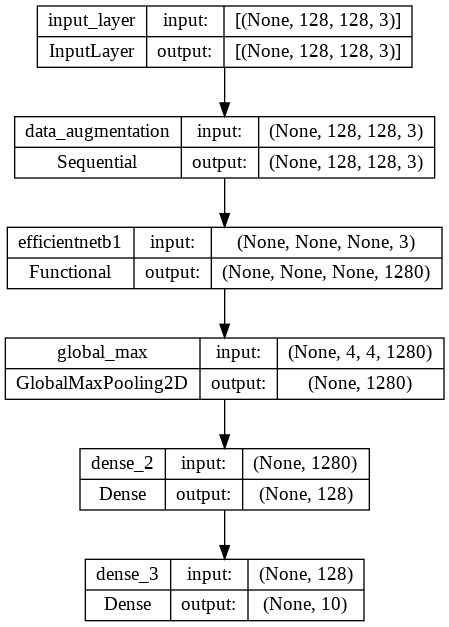

In [18]:
#
# Transfer learning
#
## Using the model EfficientNetB1 for the second experiment with the post half of the layers untrainable
## Creating the model 

base_model = tf.keras.applications.EfficientNetB1(include_top = False)
base_model.trainable = True # False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 170  # half of the whole layers

#  Fine-tuning after layer_number larger than 170
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable, end=", ")

model = tf.keras.Sequential([
  layers.Input(shape=(128,128,3),name='input_layer'),
  # layers.Rescaling(1./255),
  data_augmentation,
  # layers.Conv2D(20,3,activation='relu',padding='same'),
  base_model,
  layers.GlobalMaxPooling2D(name = "global_max"),
  # layers.MaxPool2D(pool_size=2),
  # layers.Conv2D(64,3,activation='relu'),
  # layers.MaxPool2D(pool_size=2),
  # layers.Flatten(),
  layers.Dense(128,activation='relu'),
  layers.Dense(10,activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [19]:
# Building the Model

# Setting up the callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=10) # if val loss decreases for 5 epochs in a row, stop training
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.25, # multiply the learning rate by 0.2 (reduce by 4x)
                                                 patience=3,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

#
######################################################
# Training model using augmentated data
######################################################
#
history = model.fit(ds_train, 
                    epochs=100, 
                    steps_per_epoch = len(ds_train), 
                    validation_data = ds_test,
                    validation_steps = len(ds_test), # batchSize,
                    callbacks = [early_stopping, reduce_lr])

# Test model
model.evaluate(ds_test)

Epoch 1/100
79/79 [==============================] - 29s 199ms/step - loss: 2.1989 - accuracy: 0.3394 - val_loss: 1.1054 - val_accuracy: 0.6400 - lr: 1.0000e-04
Epoch 2/100
79/79 [==============================] - 12s 147ms/step - loss: 1.0742 - accuracy: 0.6420 - val_loss: 0.7050 - val_accuracy: 0.7780 - lr: 1.0000e-04
Epoch 3/100
79/79 [==============================] - 13s 160ms/step - loss: 0.7901 - accuracy: 0.7384 - val_loss: 0.5815 - val_accuracy: 0.8120 - lr: 1.0000e-04
Epoch 4/100
79/79 [==============================] - 12s 153ms/step - loss: 0.6168 - accuracy: 0.7896 - val_loss: 0.5399 - val_accuracy: 0.8260 - lr: 1.0000e-04
Epoch 5/100
79/79 [==============================] - 12s 151ms/step - loss: 0.5157 - accuracy: 0.8286 - val_loss: 0.4895 - val_accuracy: 0.8380 - lr: 1.0000e-04
Epoch 6/100
79/79 [==============================] - 12s 154ms/step - loss: 0.4169 - accuracy: 0.8612 - val_loss: 0.4701 - val_accuracy: 0.8470 - lr: 1.0000e-04
Epoch 7/100
79/79 [===============

[0.4320862591266632, 0.8799999952316284]

### Training graph
- loss
- accuracy

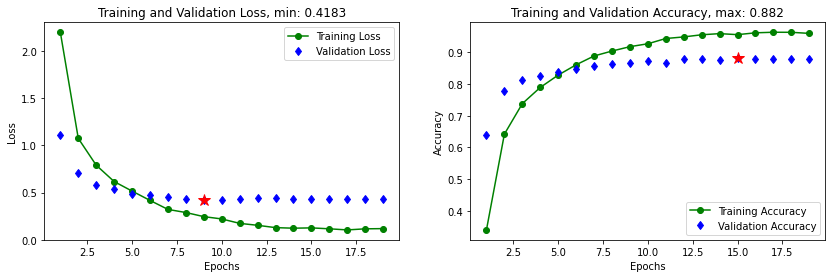

In [20]:
#############################################
# training graphs

history_dict = history.history 
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Test model


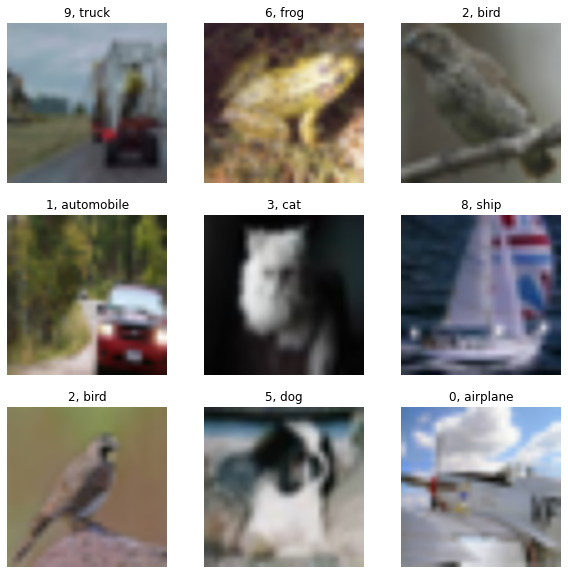

16/16 [==============================] - 3s 56ms/step
정답= 9
예측값= 9 9


0.88

In [21]:
# sample test dataset
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):  # Make a batch of images & labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()

# Test model
y_pred0 = model.predict(ds_test)
y_pred = np.argmax(y_pred0, axis=1)
y_test = [labels.numpy() for _, labels in ds_test.unbatch()]
print("정답=", y_test[0])
print("예측값=", y_pred[0], np.argmax(y_pred0[0]))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)  # model.evaluate(ds_test)

---

### TL3. 
- Using the whole trainable parameters
- Using the model EfficientNetB1 for the final experiment with all the layers trainable 

Number of layers in the base model:  340
0 input_3 True, 1 rescaling_2 True, 2 normalization_2 True, 3 tf.math.truediv_2 True, 4 stem_conv_pad True, 5 stem_conv True, 6 stem_bn True, 7 stem_activation True, 8 block1a_dwconv True, 9 block1a_bn True, 10 block1a_activation True, 11 block1a_se_squeeze True, 12 block1a_se_reshape True, 13 block1a_se_reduce True, 14 block1a_se_expand True, 15 block1a_se_excite True, 16 block1a_project_conv True, 17 block1a_project_bn True, 18 block1b_dwconv True, 19 block1b_bn True, 20 block1b_activation True, 21 block1b_se_squeeze True, 22 block1b_se_reshape True, 23 block1b_se_reduce True, 24 block1b_se_expand True, 25 block1b_se_excite True, 26 block1b_project_conv True, 27 block1b_project_bn True, 28 block1b_drop True, 29 block1b_add True, 30 block2a_expand_conv True, 31 block2a_expand_bn True, 32 block2a_expand_activation True, 33 block2a_dwconv_pad True, 34 block2a_dwconv True, 35 block2a_bn True, 36 block2a_activation True, 37 block2a_se_squeeze True,

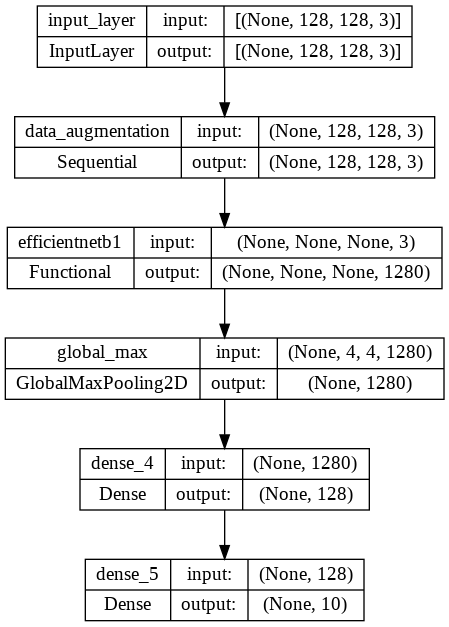

In [22]:
#
# Transfer learning
#
## Using the model EfficientNetB1 for the second experiment with all the layers trainable
## Creating the model 

base_model = tf.keras.applications.EfficientNetB1(include_top = False)
base_model.trainable = True # False

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune of all layers
for layer_number, layer in enumerate(base_model.layers):
    print(layer_number, layer.name, layer.trainable, end=", ")

model = tf.keras.Sequential([
  layers.Input(shape=(128,128,3),name='input_layer'),
  # layers.Rescaling(1./255),
  data_augmentation,
  # layers.Conv2D(20,3,activation='relu',padding='same'),
  base_model,
  layers.GlobalMaxPooling2D(name = "global_max"),
  # layers.MaxPool2D(pool_size=2),
  # layers.Conv2D(64,3,activation='relu'),
  # layers.MaxPool2D(pool_size=2),
  # layers.Flatten(),
  layers.Dense(128,activation='relu'),
  layers.Dense(10,activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss = 'sparse_categorical_crossentropy', 
              metrics = ['accuracy'])

model.summary()
keras.utils.plot_model(model, show_shapes=True)

In [23]:
# Building the Model

# Setting up the callbacks
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 10 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", # watch the val loss metric
                                                  patience=10) # if val loss decreases for 5 epochs in a row, stop training
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.25, # multiply the learning rate by 0.2 (reduce by 4x)
                                                 patience=3,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

#
######################################################
# Training model using augmentated data
######################################################
#
history = model.fit(ds_train, 
                    epochs=100, 
                    steps_per_epoch = len(ds_train), 
                    validation_data = ds_test,
                    validation_steps = len(ds_test), # batchSize,
                    callbacks = [early_stopping, reduce_lr])

# Test model
model.evaluate(ds_test)

Epoch 1/100
79/79 [==============================] - 55s 533ms/step - loss: 2.2519 - accuracy: 0.2954 - val_loss: 1.2937 - val_accuracy: 0.5550 - lr: 1.0000e-04
Epoch 2/100
79/79 [==============================] - 34s 430ms/step - loss: 1.2283 - accuracy: 0.5900 - val_loss: 0.9623 - val_accuracy: 0.6880 - lr: 1.0000e-04
Epoch 3/100
79/79 [==============================] - 31s 386ms/step - loss: 0.8966 - accuracy: 0.7004 - val_loss: 0.7453 - val_accuracy: 0.7540 - lr: 1.0000e-04
Epoch 4/100
79/79 [==============================] - 28s 360ms/step - loss: 0.6895 - accuracy: 0.7680 - val_loss: 0.5992 - val_accuracy: 0.8110 - lr: 1.0000e-04
Epoch 5/100
79/79 [==============================] - 28s 355ms/step - loss: 0.5669 - accuracy: 0.8050 - val_loss: 0.5448 - val_accuracy: 0.8300 - lr: 1.0000e-04
Epoch 6/100
79/79 [==============================] - 27s 341ms/step - loss: 0.4850 - accuracy: 0.8442 - val_loss: 0.5039 - val_accuracy: 0.8350 - lr: 1.0000e-04
Epoch 7/100
79/79 [===============

[0.42142245173454285, 0.8849999904632568]

### Training graph
- loss
- accuracy

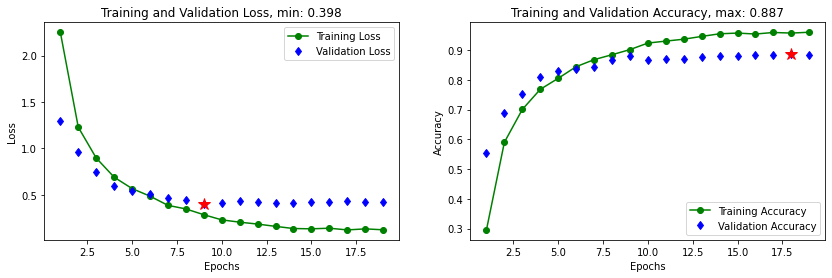

In [24]:
#############################################
# training graphs

history_dict = history.history 
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(14, 4))

plt.subplot(1,2,1)
plt.plot(epochs, loss, 'go-', label='Training Loss')
plt.plot(epochs, val_loss, 'bd', label='Validation Loss')
plt.plot(np.argmin(np.array(val_loss))+1,val_loss[np.argmin(np.array(val_loss))], 'r*', ms=12)
plt.title('Training and Validation Loss, min: ' + str(np.round(val_loss[np.argmin(np.array(val_loss))],4)))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(loss) + 1)

plt.subplot(1,2,2)
plt.plot(epochs, acc, 'go-', label='Training Accuracy') #, c='blue')
plt.plot(epochs, val_acc, 'bd', label='Validation Accuracy') #, c='red')
plt.plot(np.argmax(np.array(val_acc))+1,val_acc[np.argmax(np.array(val_acc))], 'r*', ms=12)
plt.title('Training and Validation Accuracy, max: ' + str(np.round(val_acc[np.argmax(np.array(val_acc))],4)))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Test model


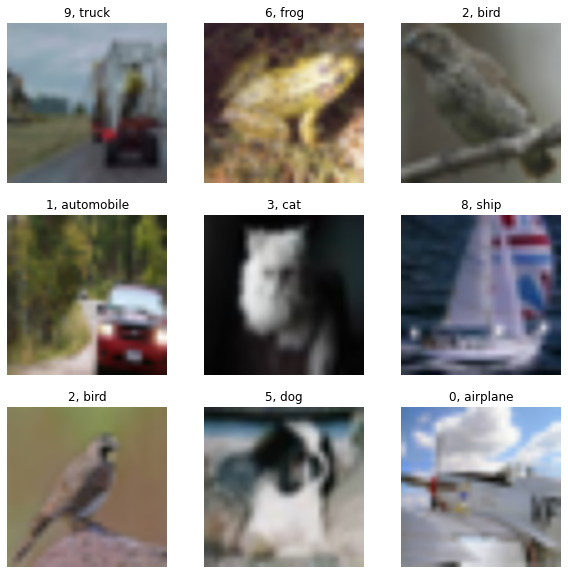

16/16 [==============================] - 3s 56ms/step
정답= 9
예측값= 9 9


0.885

In [25]:
# sample test dataset
plt.figure(figsize=(10, 10))
for images, labels in ds_test.take(1):  # Make a batch of images & labels
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(str(labels[i].numpy()) + ", " + label_names[int(labels[i])])
        plt.axis("off")
plt.show()

# Test model
y_pred0 = model.predict(ds_test)
y_pred = np.argmax(y_pred0, axis=1)
y_test = [labels.numpy() for _, labels in ds_test.unbatch()]
print("정답=", y_test[0])
print("예측값=", y_pred[0], np.argmax(y_pred0[0]))

from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)  # model.evaluate(ds_test)

---

# Summary
##ConvNet model : EfficientNetB1
## Transfer learning in 3 steps
- Full convnet using untrainable parameters : 82.7 %, Trainable params: 165,258
- Half convnet using the post half trainable parameters : 88.2 %, Trainable params: 6,282,530
- Using the whole trainable parameters : 88.7 % , Trainable params: 6,678,442

> TL2: Half convnet using the post half trainable parameters is good for transfer learning.

---